<a href="https://colab.research.google.com/github/giuseppesalvi/MLinApp-CRC-Contest-Assignment/blob/main/MLinA_CRC_Contest_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive

In [27]:
# Professor's results
# 50 epochs - 60% accuracy - 80% after selective classification

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import code from repository

In [29]:
#!rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
#!git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"

# Clone dataset repository and load data

In [30]:
!rm -r "/content/patch_dataset_noisy"
!git clone https://github.com/frpnz/dataset-BIOSTEC2018-noisy.git "/content/patch_dataset_noisy"

import zipfile
import numpy as np
from PIL import Image
filepath = "/content/patch_dataset_noisy/crc_3_noisy.zip"
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall("/content/patch_dataset_noisy")
X_test_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/X_test.npy")
Y_test_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/Y_test.npy")
X_train_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/X_train.npy")
Y_train_noisy = np.load("/content/patch_dataset_noisy/crc_3_noisy/Y_train.npy")
x_mean_train = np.load("/content/patch_dataset_noisy/crc_3_noisy/mean_x_train.npy")

# Undo preprocessing to plot images
X_train_noisy = X_train_noisy*255 + x_mean_train
X_train_noisy = X_train_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_train_noisy))
np.random.shuffle(indexes)
X_train_noisy = X_train_noisy[indexes]
Y_train_noisy = Y_train_noisy[indexes]
# Undo preprocessing to plot images
X_test_noisy = X_test_noisy*255 + x_mean_train
X_test_noisy = X_test_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_test_noisy))
np.random.shuffle(indexes)
X_test_noisy = X_test_noisy[indexes]
Y_test_noisy = Y_test_noisy[indexes]

Cloning into '/content/patch_dataset_noisy'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (4/4), done.


In [31]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
ROOTDIR_DATA = "/content/drive/MyDrive/Datasets/Teaching_dataset/"
ROOTDIR_SRC = "/content/drive/MyDrive/Datasets/Teaching_dataset/teaching-MLinAPP/src"
ROOTDIR_OUTPUT = "/content/models"
plt.style.use(os.path.join(ROOTDIR_SRC, "mystyle.mplstyle"))
import sys
sys.path.append(ROOTDIR_SRC)
#from resnet import ResNet
import matplotlib.pyplot as plt

In [32]:
tile_new_size = 64
epochs = 50 
learning_rate = 1e-3 
batch_size = 128 


# Resize to tile_new_size
X_test_noisy = np.array([np.array(Image.fromarray(x).resize((tile_new_size, tile_new_size), Image.ANTIALIAS)) for x in X_test_noisy])
X_train_noisy = np.array([np.array(Image.fromarray(x).resize((tile_new_size, tile_new_size), Image.ANTIALIAS)) for x in X_train_noisy])

In [33]:
X_test_noisy.shape

(7308, 64, 64, 3)

In [34]:
X_train_noisy.shape

(12336, 64, 64, 3)

## Prepare tf dataset

In [35]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_noisy, Y_train_noisy))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_noisy, Y_test_noisy))

## Show some images with correspondig label as title

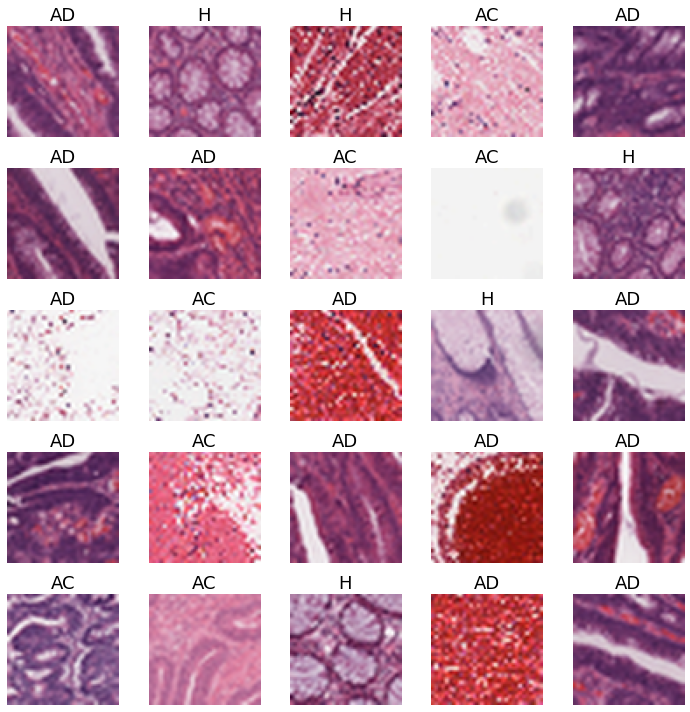

In [36]:
number2title_dict = {
    0: "AC",
    1: "AD",
    2: "H"
}

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
ax = ax.ravel()
j = 0
for X, Y in test_ds.take(25):
    ax[j].imshow(X.numpy().astype("uint8"))
    ax[j].set_title(number2title_dict[Y.numpy()])
    ax[j].axis("off")
    j += 1
plt.tight_layout()

## Prepare tf dataset pipeline

In [37]:
def process_data(image, label):
    return tf.cast(image, tf.float32)/255., tf.one_hot(label, 3, name='label', axis=-1)

In [38]:
train_ds = train_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
# TODO: shuffle?
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
y_true_test_ds = np.array([y.numpy() for x, y in test_ds])
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


# CNN definition and training
You must implement:


1.   An augmentation block
2.   Three callbacks: 

           A) tf.keras.callbacks.ModelCheckpoint
           B) tf.keras.callbacks.EarlyStopping
           C) tf.keras.callbacks.ReduceLROnPlateau


### Data Augmentation

In [39]:
# Random Crop
policy_random_crop = [
    tf.keras.Sequential([
      tf.keras.layers.RandomCrop(48, 48),
      tf.keras.layers.Resizing(64, 64)])
]

# Flip
policy_random_flip = [
    tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical")])
]

# Change Contrast
policy_random_contrast = [
    tf.keras.Sequential([
      tf.keras.layers.RandomContrast(0.3, 0.3)])
]

# Zoom
policy_random_zoom = [
    tf.keras.Sequential([
      tf.keras.layers.RandomZoom(0.3)])
]


augmentation_block = [
  policy_random_crop,
  policy_random_flip,
  policy_random_contrast,
  policy_random_zoom,
]

### Callbacks

In [40]:
checkpoint_filepath = os.path.join(ROOTDIR_OUTPUT, '/tmp/checkpoint')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    patience=10)

reduce_lr_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy', 
    factor=0.2, 
    patience=5, 
    min_lr=0.001,
    mode='auto')

callbacks = [model_checkpoint_callback, 
             early_stopping_callback, 
             reduce_lr_on_plateau_callback]

### Model

#### Resnet18 

In [41]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, 
            padding='same', 
            kernel_size=3, 
            strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, 
            kernel_size=3, 
            padding='same')
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):

        # Y = F(X) + X

        # first layer
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = tf.keras.activations.relu(Y)
        
        # second layer
        Y = self.conv2(Y)
        Y = self.bn2(Y)

        # if input has the same dimension as the output the block implements an
        # identity function, otherwise we insert a 1x1 convolutional block
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)

        # Add Residual
        Y += X 
        return tf.keras.activations.relu(Y)

In [42]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [47]:
class ResNet(tf.keras.Model):

    def __init__(self, num_classes=3):
        super(ResNet, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(
            num_classes, 
            activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

#### Train

In [49]:
model = ResNet()
model.build((1, 64, 64, 3))
model.summary()

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics="accuracy")
model.fit(train_ds, epochs=epochs, callbacks=callbacks)

Model: "res_net_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (1, 16, 16, 64)           9728      
                                                                 
 resnet_block_12 (ResnetBloc  multiple                 148736    
 k)                                                              
                                                                 
 resnet_block_13 (ResnetBloc  multiple                 526976    
 k)                                                              
                                                                 
 resnet_block_14 (ResnetBloc  multiple                 2102528   
 k)                                                              
                                                                 
 resnet_block_15 (ResnetBloc  multiple                 8399360   
 k)                                                      

In [59]:
# Copy checkpoint to drive
#!cp -r ./checkpoint drive/MyDrive/Datasets/

# Copy checkpoint from drive
#!cp -r drive/MyDrive/Datsets/checkpoint .

In [60]:
# Load model from checkpoint
model = tf.keras.models.load_model(checkpoint_filepath)

## Test the model
Plot a confusion matrix

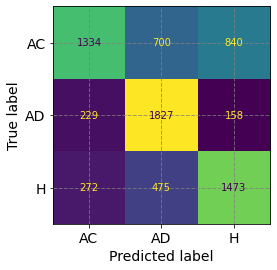

58/58 [==============================] - 2s 37ms/step - loss: 1.2875 - accuracy: 0.6341
Accuracy: 0.63


In [91]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_predicted = np.argmax(model.predict(test_ds, batch_size=batch_size), axis=1)
y_labels = np.argmax(y_true_test_ds, axis=1)
conf_matrix = confusion_matrix(y_labels, y_predicted)

ConfusionMatrixDisplay.from_predictions(y_labels, y_predicted, display_labels=["AC","AD","H"], colorbar=False)
# ConfusionMatrixDisplay.from_predictions(y_labels, y_predicted, display_labels=["AC","AD","H"], colorbar=False, normalize="true")

plt.show()

accuracy = model.evaluate(test_ds)[1]
print("Accuracy: {:.2f}".format(accuracy))

# Selective classification applied to histological images

In [ ]:
[...]